The goal of this competition is to predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. The telemetry data containing these properties and the machine infections was generated by combining heartbeat and threat reports collected by Microsoft's endpoint protection solution, Windows Defender.

Each row in this dataset corresponds to a machine, uniquely identified by a MachineIdentifier. HasDetections is the ground truth and indicates that Malware was detected on the machine. Using the information and labels in train.csv, you must predict the value for HasDetections for each machine in test.csv.

The sampling methodology used to create this dataset was designed to meet certain business constraints, both in regards to user privacy as well as the time period during which the machine was running. Malware detection is inherently a time-series problem, but it is made complicated by the introduction of new machines, machines that come online and offline, machines that receive patches, machines that receive new operating systems, etc. While the dataset provided here has been roughly split by time, the complications and sampling requirements mentioned above may mean you may see imperfect agreement between your cross validation, public, and private scores! Additionally, this dataset is not representative of Microsoft customers’ machines in the wild; it has been sampled to include a much larger proportion of malware machines.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.experimental import enable_hist_gradient_boosting
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split
from sklearn import tree, linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
# set up display area to show dataframe in jupyter qtconsole
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# We need to explicitly specify data types when reading csv, otherwise it is very memory consuming
# and we will get the warning "Specify dtype option on import or set low_memory=False"
# So, we will manually defined the data types

# P.S. I have loaded the sample data and exported train_data.dtypes
# these are the data types for fast loading

datatypes = {
    'ProductName': np.int8,
    'IsBeta': np.int8,
    'RtpStateBitfield': np.int64,
    'IsSxsPassiveMode': np.int8,
    'AVProductStatesIdentifier': np.int64,
    'AVProductsInstalled': np.int64,
    'AVProductsEnabled': np.int64,
    'CountryIdentifier': np.int64,
    'CityIdentifier': np.int64,
    'OrganizationIdentifier': np.int64,
    'GeoNameIdentifier': np.int64,
    'LocaleEnglishNameIdentifier': np.int64,
    'Platform': np.int16,
    'Processor': np.int8,
    'OsSuite': np.int64,
    'OsPlatformSubRelease': np.int16,
    'SkuEdition': np.int8,
    'IsProtected': np.int64,
    'AutoSampleOptIn': np.int8,
    'SMode': np.int64,
    'IeVerIdentifier': np.int64,
    'SmartScreen': np.int8,
    'Firewall': np.int64,
    'UacLuaenable': np.int64,
    'Census_MDC2FormFactor': np.int8,
    'Census_DeviceFamily': np.int8,
    'Census_OEMNameIdentifier': np.int64,
    'Census_ProcessorManufacturerIdentifier': np.int64,
    'Census_ProcessorModelIdentifier': np.int64,
    'Census_PrimaryDiskTotalCapacity': np.float64,
    'Census_PrimaryDiskTypeName': np.int8,
    'Census_SystemVolumeTotalCapacity': np.float64,
    'Census_HasOpticalDiskDrive': np.int8,
    'Census_TotalPhysicalRAM': np.float64,
    'Census_ChassisTypeName': np.int8,
    'Census_InternalPrimaryDiagonalDisplaySizeInInches': np.float64,
    'Census_InternalPrimaryDisplayResolutionHorizontal': np.int64,
    'Census_InternalPrimaryDisplayResolutionVertical': np.int64,
    'Census_PowerPlatformRoleName': np.int8,
    'Census_InternalBatteryNumberOfCharges': np.float64,
    'Census_OSArchitecture': np.int8,
    'Census_OSBranch': np.int8,
    'Census_OSBuildNumber': np.int64,
    'Census_OSBuildRevision': np.int64,
    'Census_OSEdition': np.int8,
    'Census_OSInstallTypeName': np.int8,
    'Census_OSInstallLanguageIdentifier': np.int64,
    'Census_OSUILocaleIdentifier': np.int64,
    'Census_OSWUAutoUpdateOptionsName': np.int8,
    'Census_IsPortableOperatingSystem': np.int8,
    'Census_GenuineStateName': np.int8,
    'Census_ActivationChannel': np.int8,
    'Census_IsFlightsDisabled': np.int64,
    'Census_FlightRing': np.int8,
    'Census_ThresholdOptIn': np.int64,
    'Census_FirmwareManufacturerIdentifier': np.int64,
    'Census_FirmwareVersionIdentifier': np.int64,
    'Census_IsSecureBootEnabled': np.int8,
    'Census_IsWIMBootEnabled': np.int64,
    'Census_IsVirtualDevice': np.int64,
    'Census_IsTouchEnabled': np.int8,
    'Census_IsPenCapable': np.int8,
    'Census_IsAlwaysOnAlwaysConnectedCapable': np.int64,
    'Wdft_IsGamer': np.int64,
    'Wdft_RegionIdentifier': np.int64,
    'EngineVersion_1': np.int64,
    'EngineVersion_2': np.int64,
    'EngineVersion_3': np.int64,
    'EngineVersion_4': np.int64,
    'AppVersion_1': np.int64,
    'AppVersion_2': np.int64,
    'AppVersion_3': np.int64,
    'AppVersion_4': np.int64,
    'AvSigVersion_1': np.int64,
    'AvSigVersion_2': np.float64,
    'AvSigVersion_3': np.int64,
    'AvSigVersion_4': np.int64,
    'OsVer_1': np.int64,
    'OsVer_2': np.int64,
    'OsVer_3': np.int64,
    'OsVer_4': np.int64,
    'OsBuildLab_1': np.int64,
    'OsBuildLab_2': np.int64,
    'OsBuildLab_3': np.int8,
    'OsBuildLab_4': np.int8,
    'OsBuildLab_5': np.int64,
    'OsBuildLab_6': np.int64,
    'Census_OSVersion_1': np.int64,
    'Census_OSVersion_2': np.int64,
    'Census_OSVersion_3': np.int64,
    'Census_OSVersion_4': np.int64,
    'CORE': np.int64,
    'EDUCATION': np.int64,
    'PRO': np.int64,
    'ENTERPRISE': np.int64,
    'CLOUD': np.int64,
    'SERVER': np.int64,
    'EVALUATION': np.int64,
    'ScreenProportion': np.float64,
    'ScreenDimensions': np.int64,
    'CapacityDifference': np.float64,
    'CapacityRatio': np.float64,
    'RAMByCores': np.float64,
    'HasDetections': np.int8
}

full_features = pd.read_csv('bruteforced_engineered.csv', dtype=datatypes, index_col="MachineIdentifier")
full_labels = full_features["HasDetections"]

# Dropping labels ["HasDetections"] from training dataset
full_features = full_features.drop(["HasDetections"], axis=1)

In [4]:
print (full_features.shape)

(180000, 103)


In [5]:
full_features.head(10)

,ProductName,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsSuite,OsPlatformSubRelease,SkuEdition,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryNumberOfCharges,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,EngineVersion_1,EngineVersion_2,EngineVersion_3,EngineVersion_4,AppVersion_1,AppVersion_2,AppVersion_3,AppVersion_4,AvSigVersion_1,AvSigVersion_2,AvSigVersion_3,AvSigVersion_4,OsVer_1,OsVer_2,OsVer_3,OsVer_4,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,OsBuildLab_4,OsBuildLab_5,OsBuildLab_6,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,Census_OSVersion_4,CORE,EDUCATION,PRO,ENTERPRISE,CLOUD,SERVER,EVALUATION,ScreenProportion,ScreenDimensions,CapacityDifference,CapacityRatio,RAMByCores
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cf84bf65d2012fca3354a563bdd2d1aa,1,0,7,0,23657,2,1,20,107328,-1,40,88,10,1,768,504,52,1,0,0,137,6,1,1,6,1,1443,5,2998,953869.0,1,944415.0,0,8192.0,1,13.2,1920,1080,1,0.000000e+00,1,24,17134,228,1,1,8,31,1,0,1,1,0,1,0,355,19973,1,0,0,1,1,0,0,11,1,1,15200,1,4,18,1807,18075,1,275.0,932,0,10,0,0,0,17134,1,1,7,180410,1804,10,0,17134,228,0,0,0,0,0,0,0,1.777778,19201080,0.990089,-9454.0,2048.0
08a6070b0933283e11bdfbef96502a3d,1,0,7,0,53447,1,1,88,142802,48,117,115,10,3,256,503,55,1,0,0,117,6,1,1,2,1,1915,5,3428,476940.0,1,476477.0,0,2048.0,1,15.5,1366,768,1,0.000000e+00,3,23,16299,431,2,4,17,64,1,0,1,1,0,1,0,142,12589,0,0,0,0,0,0,0,3,1,1,15200,1,4,18,1807,18075,1,275.0,722,0,10,0,0,0,16299,15,3,9,170928,1534,10,0,16299,431,0,0,0,0,0,0,0,1.778646,13660768,0.999029,-463.0,1024.0
b992168f939bc71ca3545c7109128719,1,0,7,0,53447,1,1,60,86819,27,240,233,10,1,768,504,52,1,0,0,137,4,1,1,2,1,2206,5,3244,152627.0,1,152076.0,1,4096.0,1,27.9,1920,1080,2,4.294967e+09,1,24,17134,191,1,2,9,34,2,0,1,1,0,1,-1,500,33041,0,-1,0,0,0,0,0,15,1,1,15100,1,4,16,17656,18052,1,273.0,366,0,10,0,0,0,17134,1,1,7,180410,1804,10,0,17134,191,0,0,0,0,0,0,0,1.777778,19201080,0.996390,-551.0,2048.0
f279600b8d7019cae891aa100171cc33,1,0,7,0,46413,2,1,82,144184,18,277,75,10,1,768,504,52,1,0,0,137,6,1,1,2,1,585,5,1985,476940.0,1,475447.0,0,4096.0,1,15.5,1366,768,1,0.000000e+00,1,24,17134,228,1,4,8,31,1,0,1,2,0,1,0,556,63417,1,0,0,0,0,0,1,13,1,1,15200,1,4,18,1807,18075,1,275.0,845,0,10,0,0,0,17134,1,1,7,180410,1804,10,0,17134,228,0,0,0,0,0,0,0,1.778646,13660768,0.996870,-1493.0,2048.0
8d9824ee99af78fd030fee61a27f5478,1,0,7,0,62773,1,1,18,37376,-1,277,75,10,1,256,503,55,0,0,0,111,4,1,1,1,1,2102,5,2719,953869.0,1,935162.0,0,8192.0,2,20.0,1600,900,2,4.294967e+09,1,23,16299,192,2,5,8,31,2,0,3,2,0,3,-1,486,51364,0,-1,0,0,0,0,-1,-1,1,1,14104,0,4,12,16299,15,1,251.0,42,0,10,0,0,0,16299,15,1,9,1709

In [6]:
# Let's see some details of the loaded data
full_features.describe()

,ProductName,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsSuite,OsPlatformSubRelease,SkuEdition,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryNumberOfCharges,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,EngineVersion_1,EngineVersion_2,EngineVersion_3,EngineVersion_4,AppVersion_1,AppVersion_2,AppVersion_3,AppVersion_4,AvSigVersion_1,AvSigVersion_2,AvSigVersion_3,AvSigVersion_4,OsVer_1,OsVer_2,OsVer_3,OsVer_4,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,OsBuildLab_4,OsBuildLab_5,OsBuildLab_6,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,Census_OSVersion_4,CORE,EDUCATION,PRO,ENTERPRISE,CLOUD,SERVER,EVALUATION,ScreenProportion,ScreenDimensions,CapacityDifference,CapacityRatio,RAMByCores
count,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,1.800000e+05,180000.000000,1.800000e+05,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,1.800000e+05,180000.000000,180000.000000,180000.00000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.0,180000.0,180000.000000,180000.000000,180000.0,180000.000000,180000.000000,180000.000000,180000.0,180000.000000,180000.000000,180000.0,180000.000000,180000.000000,180000.000000,180000.0,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.0,180000.0,180000.00000,180000.000000,180000.0,180000.0,180000.0,180000.0,180000.0,180000.0,180000.0,180000.000000,1.800000e+05,180000.000000,1.800000e+05,180000.000000
mean,1.010406,0.000022,6.817367,0.017333,47675.479406,1.315689,1.011450,107.874467,78400.258767,16.918650,169.586194,122.508811,13.313717,1.182194,573.991194,477.402028,52.639683,0.937339,0.000033,-0.060567,125.659606,4.850294,0.958217,0.991989,2.196072,1.001689,2196.474717,4.505772,2360.734972,5.093768e+05,1.422911,3.739974e+05,0.077533,6056.931422,1.638467,16.602685,1540.032506,893.355828,1.402289,1.097317e+09,1.182372,22.100283,15840.15020,973.759728,1.401906,2.945578,14.506017,60.454800,1.881439,0.000628,1.148606,1.520306,-0.017783,1.093378,-0.634961,395.181656,32369.515422,0.484244,-0.634139,0.005667,0.126572,0.03856

In [7]:
# Trying PCA and checking the variances
# Looks like 2 components are enough for 
# 99.99% precision. Will use at least 10 anyways

model = PCA(n_components=10)
pca_results = np.array(model.fit_transform(full_features))

# We need cumulative sums by components
variances = model.explained_variance_ratio_.cumsum()

for k in range(len(variances)):
    print ("k =", k + 1, " Variance =", variances[k])

k = 1  Variance = 0.9999957866256143
k = 2  Variance = 0.999999910643485
k = 3  Variance = 0.9999999725823133
k = 4  Variance = 0.9999999990332104
k = 5  Variance = 0.9999999997575795
k = 6  Variance = 0.9999999998844408
k = 7  Variance = 0.9999999999426067
k = 8  Variance = 0.9999999999660799
k = 9  Variance = 0.9999999999775256
k = 10  Variance = 0.9999999999856475


In [8]:
# np.random.seed(0)

# Shuffle the data and for testing purposes take only 200,000 records after shuffling
# For the final result, the complete data will be processed
shuffle = np.random.permutation(np.arange(full_features.shape[0]))[:200000]

# Split the data to training and testing
train_features, test_features, train_labels, test_labels = \
    train_test_split(full_features.values[shuffle], full_labels.values[shuffle], train_size=0.80)

print (train_features.shape, test_features.shape, train_labels.shape, test_labels.shape)

(144000, 103) (36000, 103) (144000,) (36000,)


In [9]:
# Run the data through standard scaler. Some models perform better when 
# the data is regularized
scaler = StandardScaler()
scaler.fit(train_features)

normalized_train_features = scaler.transform(train_features)
normalized_test_features = scaler.transform(test_features)

In [10]:
# PCA = 2 gives us 0.999+ accuracy, but let's choose at least 10 for number of components
model = PCA(n_components=10)

train_pca = np.array(model.fit_transform(normalized_train_features))
test_pca = np.array(model.transform(normalized_test_features))

print (train_pca.shape, test_pca.shape)

(144000, 10) (36000, 10)


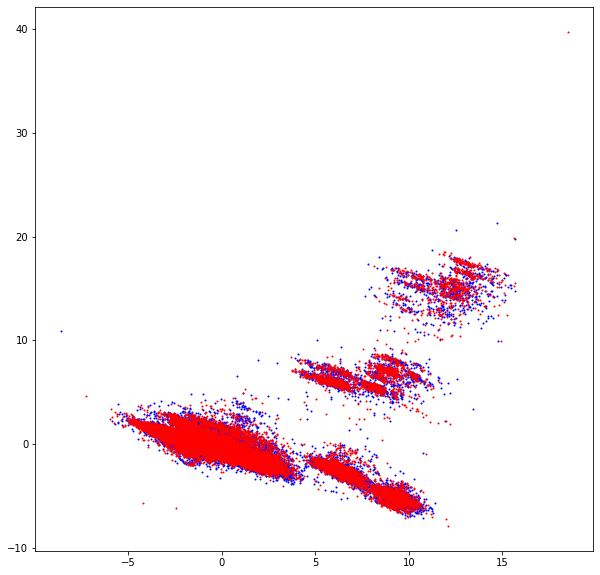

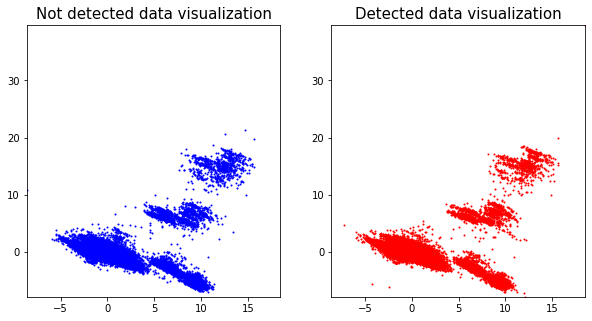

In [11]:
# Lets visually look at the positive and negative predictions

model = PCA(n_components=2)

train_pca_visual = np.array(model.fit_transform(normalized_train_features))

# when train_label == 1, then malware was detected
# when train_label == 0, malware was NOT detected

plt.figure(figsize=(10,10))

plt.plot(train_pca_visual[:,0][train_labels==0], train_pca_visual[:,1][train_labels==0], 'bo', markersize=1)
plt.plot(train_pca_visual[:,0][train_labels==1], train_pca_visual[:,1][train_labels==1], 'ro', markersize=1)


plt.figure(figsize=(10,5))
for i in range(2):
    color = 'bo' if i == 0 else 'ro'
    title = "Not detected data visualization" if i == 0 else "Detected data visualization"
    plt.subplot(1, 2, i + 1)
    plt.plot(train_pca_visual[:,0][train_labels==i], train_pca_visual[:,1][train_labels==i], color, markersize=1)
    plt.title(title, fontsize = 15)
    plt.ylim(train_pca_visual[:,1].min(), train_pca_visual[:,1].max())
    plt.xlim(train_pca_visual[:,0].min(), train_pca_visual[:,0].max())


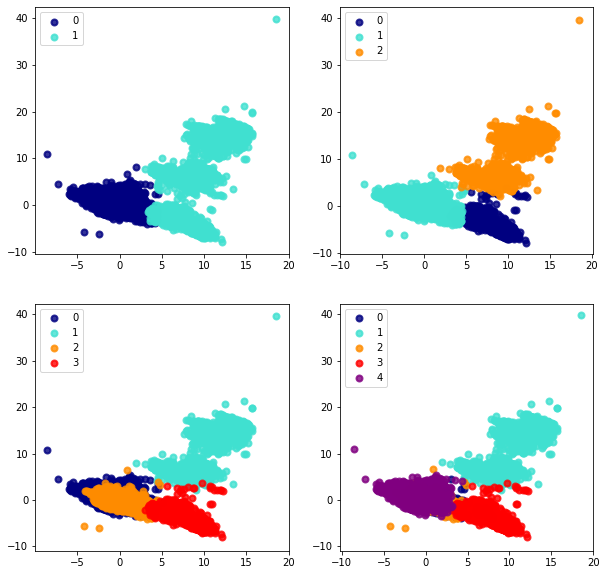

In [12]:
# Apply k-means + PCA + plot

from sklearn.cluster import KMeans

plot_data_length = 200000
colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple', 'green', 'black']

fig, ax = plt.subplots(2,2,figsize=(10,10))

for k in range(2,6):
    # Fit the training data to a k-means clustering estimator model
    kmeans = KMeans(n_clusters=k).fit(train_pca[:plot_data_length])

    # Retrieve the labels assigned to each training sample
    kmeans_y = kmeans.labels_

    for color, cat in zip(colors, range(k)):
        p = ax[0 if k < 4 else 1,k % 2]
        p.scatter(train_pca[:plot_data_length][kmeans_y==cat, 0],
            train_pca[:plot_data_length][kmeans_y==cat, 1],
            color=color, alpha=.8, lw=2, label=cat)
        p.legend(loc='best', shadow=False, scatterpoints=1)


In [13]:
# Trying logistic regression and PCA
# The accuracy score would be 0.562275

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for s in solvers:
    # instantiate the model
    logreg = LogisticRegression(solver=s)

    # fit the model with data
    logreg.fit(train_pca, train_labels)

    # store the predicted response values
    y_pred = logreg.predict(test_pca)
    logreg_accuracy_score = accuracy_score(test_labels, y_pred)

    print('PCA =', train_pca.shape[1], s, 'logreg_accuracy_score', logreg_accuracy_score)

PCA = 10 newton-cg logreg_accuracy_score 0.5626944444444445
PCA = 10 lbfgs logreg_accuracy_score 0.5626944444444445
PCA = 10 liblinear logreg_accuracy_score 0.5626944444444445
PCA = 10 sag logreg_accuracy_score 0.5626944444444445
PCA = 10 saga logreg_accuracy_score 0.5626944444444445


In [14]:
# Trying logistic regression with regularized data
# The accuracy score would be 0.607825

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for s in solvers:
    # instantiate the model
    logreg = LogisticRegression(solver=s)

    # fit the model with data
    logreg.fit(normalized_train_features, train_labels)

    # store the predicted response values
    y_pred = logreg.predict(normalized_test_features)
    logreg_accuracy_score = accuracy_score(test_labels, y_pred)

    print('Features', normalized_train_features.shape[1], s, 'logreg_accuracy_score', logreg_accuracy_score)

Features 103 newton-cg logreg_accuracy_score 0.6085277777777778
Features 103 lbfgs logreg_accuracy_score 0.6085555555555555
Features 103 liblinear logreg_accuracy_score 0.6085555555555555
Features 103 sag logreg_accuracy_score 0.6086388888888888
Features 103 saga logreg_accuracy_score 0.6088333333333333


In [15]:
algorithms = {
    "HistGradientBoosting": ske.HistGradientBoostingClassifier(random_state=123),
    "DecisionTree": tree.DecisionTreeClassifier(max_depth=10,random_state=123),
    "RandomForest": ske.RandomForestClassifier(n_estimators=50,random_state=123),
    "GradientBoosting": ske.GradientBoostingClassifier(n_estimators=50,random_state=123),
    "AdaBoost": ske.AdaBoostClassifier(n_estimators=200,random_state=123),
    "Neural Net MLP": MLPClassifier(random_state=123),
}

In [16]:
results = {}
print('Testing algorithms using original dataset...')
print()
for algo in algorithms:
    clf = algorithms[algo]
    clf.fit(train_features, train_labels)
    score = clf.score(test_features, test_labels)
    print("%s : %f %%" % (algo, score*100))
    results[algo] = score
    
winner = max(results, key=results.get)
print()
print(f'Winning algorithm is {winner} with a {results[winner]*100}% accuracy')

Testing algorithms using original dataset...

HistGradientBoosting : 63.886111 %
DecisionTree : 61.405556 %
RandomForest : 62.483333 %
GradientBoosting : 62.211111 %
AdaBoost : 62.658333 %
Neural Net MLP : 49.583333 %

Winning algorithm is HistGradientBoosting with a 63.88611111111111% accuracy


In [17]:
results = {}
print('Testing algorithms using normalized original dataset...')
print()
for algo in algorithms:
    clf = algorithms[algo]
    clf.fit(normalized_train_features, train_labels)
    score = clf.score(normalized_test_features, test_labels)
    print("%s : %f %%" % (algo, score*100))
    results[algo] = score
    
winner = max(results, key=results.get)
print()
print(f'Winning algorithm is {winner} with a {results[winner]*100}% accuracy')

Testing algorithms using normalized original dataset...

HistGradientBoosting : 63.886111 %
DecisionTree : 61.386111 %
RandomForest : 62.266667 %
GradientBoosting : 62.213889 %
AdaBoost : 62.580556 %
Neural Net MLP : 60.952778 %

Winning algorithm is HistGradientBoosting with a 63.88611111111111% accuracy


In [18]:
results = {}
print('Testing algorithms using PCA...')
print()
for algo in algorithms:
    clf = algorithms[algo]
    clf.fit(train_pca, train_labels)
    score = clf.score(test_pca, test_labels)
    print("%s : %f %%" % (algo, score*100))
    results[algo] = score
    
winner = max(results, key=results.get)
print()
print(f'Winning algorithm is {winner} with a {results[winner]*100}% accuracy')

Testing algorithms using PCA...

HistGradientBoosting : 58.538889 %
DecisionTree : 56.363889 %
RandomForest : 57.041667 %
GradientBoosting : 57.358333 %
AdaBoost : 57.086111 %
Neural Net MLP : 58.958333 %

Winning algorithm is Neural Net MLP with a 58.958333333333336% accuracy


In [19]:
from sklearn.metrics import roc_curve, auc

clf = ske.HistGradientBoostingClassifier(random_state=123)
clf.fit(normalized_train_features, train_labels)
score = clf.score(normalized_test_features, test_labels)
predicted = clf.predict(normalized_test_features)

false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, predicted)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc, false_positive_rate, true_positive_rate, thresholds)

0.6388070698103959 [0.        0.3681411 1.       ] [0.         0.64575524 1.        ] [2 1 0]


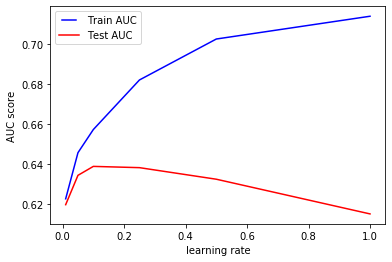

In [20]:
# Playing with learning rate
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]

train_results = []
test_results = []

for eta in learning_rates:
   model = ske.HistGradientBoostingClassifier(random_state=123,learning_rate=eta)
   model.fit(normalized_train_features, train_labels)   
   train_pred = model.predict(normalized_train_features)  

   false_positive_rate, true_positive_rate, thresholds = roc_curve(train_labels, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
    
   test_pred = model.predict(normalized_test_features)   
   false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, test_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

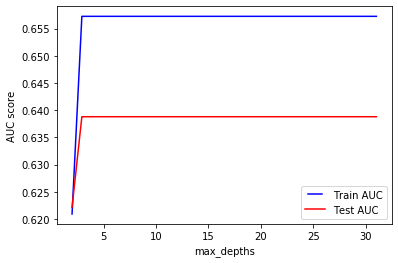

In [21]:
# Playing with max depth
max_depths = np.linspace(2, 31, 32, endpoint=True)

train_results = []
test_results = []

for max_depth in max_depths:
   model = ske.HistGradientBoostingClassifier(random_state=123,max_depth=max_depth)
   model.fit(normalized_train_features, train_labels)   
   train_pred = model.predict(normalized_train_features)  

   false_positive_rate, true_positive_rate, thresholds = roc_curve(train_labels, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
    
   test_pred = model.predict(normalized_test_features)   
   false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, test_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_depths')
plt.show()


In [ ]:
# Playing with max iterations
max_iters = np.linspace(100, 1000, 10, endpoint=True)

train_results = []
test_results = []

for max_iter in max_iters:
   model = ske.HistGradientBoostingClassifier(random_state=123,max_iter=int(max_iter))
   model.fit(normalized_train_features, train_labels)   
   train_pred = model.predict(normalized_train_features)  

   false_positive_rate, true_positive_rate, thresholds = roc_curve(train_labels, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
    
   test_pred = model.predict(normalized_test_features)   
   false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, test_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_iters, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_iters, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_iters')
plt.show()


In [ ]:
# Playing with max leaf nodes
max_leaf_nodes = np.linspace(25, 165, 11, endpoint=True)

train_results = []
test_results = []

for max_leaf_node in max_leaf_nodes:
   model = ske.HistGradientBoostingClassifier(random_state=123,max_leaf_nodes=int(max_leaf_node))
   model.fit(normalized_train_features, train_labels)   
   train_pred = model.predict(normalized_train_features)  

   false_positive_rate, true_positive_rate, thresholds = roc_curve(train_labels, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
    
   test_pred = model.predict(normalized_test_features)   
   false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, test_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_leaf_nodes, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_leaf_nodes, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_leaf_nodes')
plt.show()


In [ ]:
# Playing with min sample leafs
min_samples_leafs = np.linspace(15, 145, 11, endpoint=True)

train_results = []
test_results = []

for min_samples_leaf in min_samples_leafs:
   model = ske.HistGradientBoostingClassifier(random_state=123,min_samples_leaf=int(min_samples_leaf))
   model.fit(normalized_train_features, train_labels)   
   train_pred = model.predict(normalized_train_features)  

   false_positive_rate, true_positive_rate, thresholds = roc_curve(train_labels, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
    
   test_pred = model.predict(normalized_test_features)   
   false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, test_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min_samples_leafs')
plt.show()
